<a href="https://colab.research.google.com/github/Mayuri103120/DL_Learnings/blob/main/DL_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal: To Visualize and Undersatnd different optimizers in DL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

%matplotlib inline

In [2]:
class QuadFunc:
  def __init__(self,a, b, c, d, e):
    self.a = a
    self.b = b
    self.c = c
    self.d = d
    self.e = e

  def getParams(self, x, y):
    if y is None:
      y =x[1]
      x = x[0]
    return x,y

  def __call__(self, x, y = None):
    x,y = self.getParams(x,y)
    return 0.5 * (self.a*x**2 + self.b*y**2) + self.c * x * y + self.d *x +self.e*y

  def grad(self, x, y = None):
    x, y = self.getParams(x,y)
    return torch.tensor([self.a * x + self.c *y +self.d, self.b * y + self.c * x + self.e])

  def hess (self, x, y=None):
    x, y = self.getParams(x,y)
    return torch.tensor([[self.a, self.c], [self.c, self.b]])

class GradientDescent:
  def __init__(self, lr =1, b1=0.9, b2 = 0.999):
    self.lr = lr
    self.b1 = b1
    self.b2 = b2

    self.v = 0
    self.w = 0
    self.t = 0

    self.eps = 1e-9

  def __call__(self, grad, hess):
    self.t += 1
    self.v = self.b1*self.v + (1-self.b1)*grad
    self.w = self.b2*self.w + (1-self.b2)*grad**2

    vcorr = self.v/ (1-self.b1**self.t)
    wcorr = self.w/ (1-self.b2**self.t) if self.b2 != 0 else 1
    return -1*self.lr*vcorr/(wcorr**0.5 + self.eps)

class Newtons:
  def __init__(self, lr=1):
    self.lr = lr

  def __call__(self, grad,hess):
    return -1*self.lr*torch.matmul(torch.inverse(hess), grad)

def runOptim(init, optim, func,steps):
  curpos = init
  path = [curpos]

  for _ in range(steps):
    grad = func.grad(curpos)
    hess = func.hess(curpos)

    dx = optim(grad, hess)
    curpos = curpos + dx
    path.append(curpos)

  return path

def showPath(func, init, paths, labels, colors,levels):
  x = torch.arange(-10,10,0.05)
  y = torch.arange(-10,10,0.05)

  xx, yy = torch.meshgrid(x,y)
  zz = func(xx,yy)

  fig, ax = plt.subplots(1,1,figsize=(16,10))
  cp = ax.contourf(xx,yy,zz,levels)
  fig.colorbar(cp)

  ax.plot(init[0],init[1],'ro')
  ax.text(init[0]+0.5,init[1]+0.5,'Initial Point', color ='white')


  for pnum in range(len(paths)):
    for i in range(len(paths[pnum])-1):
      curpos = paths[pnum][i]
      d = paths[pnum][i+1] - curpos
      ax.arrow(curpos[0], curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
      ax.text(curpos[0]+d[0], curpos[1]+d[1],str(i),color='white')

  legends = []
  for col in colors:
    legends.append(mpatches.Patch(color=col))
  ax.legend(legends,labels)

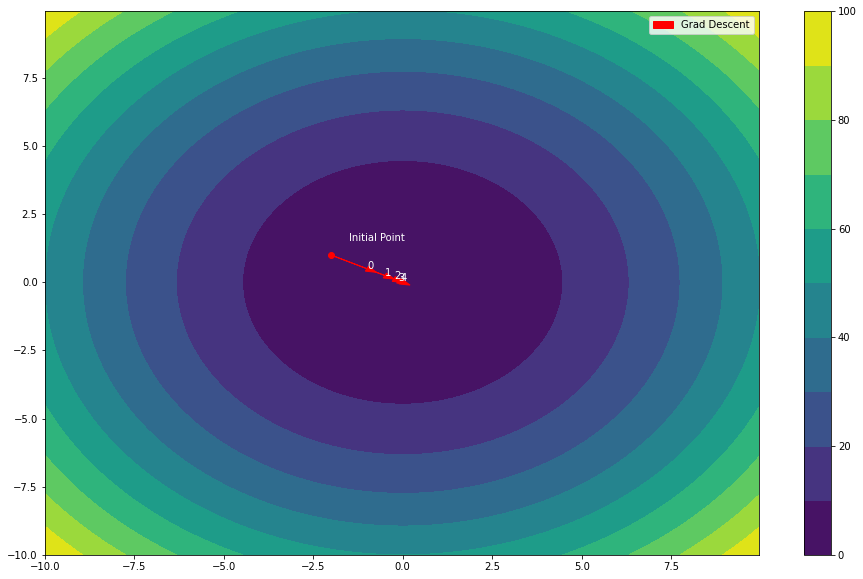

In [4]:
f = QuadFunc(a= 1.0, b=1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0,1.0])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0)
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=10)